In [1]:
# MNIST with an MLP, from scratch

# - Step 1: build an MLP from scratch to solve MNIST. Question set: https://fleuret.org/dlc/materials/dlc-practical-3.pdf
# - Step 2: debug your network with backprop ninja and a reference implementation using torch's .backward()
# - Step 3: build the same MLP but will full pytorch code (nn.Linear, etc.)

In [1]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from utils import load_data

In [3]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


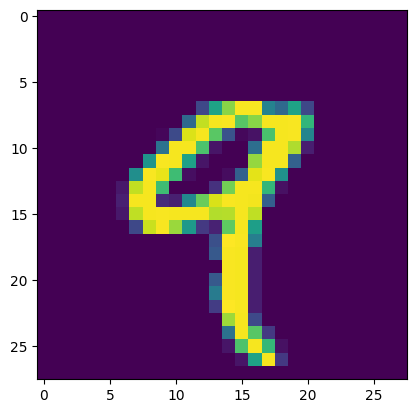

In [4]:
plt.imshow(train_input[4].view((28,28)))

In [5]:
def compute_accuracy (preds, targets):
    """ Computes the accuracy between predictions and targets. Data is expected to be one-hot encoded. """
    _, idx1 = torch.max(preds, dim=1)
    _, idx2 = torch.max(targets, dim=1)
    d = idx1 == idx2
    return d.int().float().mean().item()

In [6]:
# unit test
# this cell should return 0.75
preds = torch.zeros((4,7))
preds[0,1] = 1
preds[1,4] = 1
preds[2,2] = 1
preds[3,6] = 1
targets = torch.zeros((4,7))
targets[0,1] = 1
targets[1,4] = 1
targets[2,2] = 1
targets[3,2] = 1
compute_accuracy(preds, targets)

0.75

In [7]:
def sigma(x):
    return torch.tanh(x)

def dsigma(x):
    return 1 - torch.pow(sigma(x), 2)

In [8]:
def loss (v,t):
    return torch.sum(torch.pow(v-t, 2))

def dloss(v,t):
    return -2 * (t - v)

In [9]:
# sanity check
v = torch.randn((3, 6), dtype=torch.float32)
t = torch.randn((3, 6), dtype=torch.float32)
l=loss(v,t)
dloss(v,t)

tensor([[-1.5787, -0.9364,  3.6656,  0.7376, -1.5734,  2.3179],
        [-2.0180,  1.5956,  0.2792, -2.0212,  2.1317, -0.4389],
        [-3.9487,  3.3172,  2.7199, -0.5366, -1.0881, -0.2018]])

In [10]:
# multiply targets by 0.9 to be in the range of tanh
train_target *= 0.9
test_target *= 0.9

### Step 1: Backprop ninja

In [11]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
# DO NOT MODIFY IT
#
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [12]:
torch.manual_seed(1337)
w1 = torch.randn((784, 50))
b1 = torch.randn((50))
w2 = torch.randn((50, 10))
b2 = torch.randn((10))
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad = True

In [13]:
x1 = train_input[:5]
y1 = train_target[:5]
z1 = x1@w1 + b1
h1 = sigma(z1)
z2 = h1@w2 + b2
h2 = sigma(z2)
l = loss(h2, y1)
h2.shape, l

(torch.Size([5, 10]), tensor(43.2825, grad_fn=<SumBackward0>))

In [14]:
# Force pytorch to retain grade for intermediate nodes and reset grad for parameters
# DO NOT MODIFY THIS CODE
#
others = [h2,z2,h1,z1]
for p in parameters:
    p.grad = None
for t in others:
    t.retain_grad()
l.backward()
print(f'loss={l}')

loss=43.28252410888672


In [15]:
b2.grad.shape

torch.Size([10])

In [16]:
# here we compare our gradient to the reference gradient computed by pytorch
dl = 1.0
dh2 = dloss(h2, y1)*dl
cmp('h2',dh2,h2)
dz2 = dsigma(z2)*dh2
cmp('z2',dz2, z2)
dw2 = h1.T @ dz2
cmp('w2',dw2, w2)
db2 = dz2.sum(axis=0, keepdim=True)
cmp('b2',db2, b2)
dh1 = dz2 @ w2.T
cmp('h1',dh1, h1)
dz1 = dsigma(z1)*dh1
cmp('z1', dz1, z1)
dw1 = x1.T @ dz1
cmp('w1', dw1, w1)
db1 = dz1.sum(axis=0, keepdim=True)
cmp('b1', db1, b1)


h2              | exact: True  | approximate: True  | maxdiff: 0.0
z2              | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h1              | exact: True  | approximate: True  | maxdiff: 0.0
z1              | exact: True  | approximate: True  | maxdiff: 0.0
w1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [17]:
lr = 0.1
with torch.no_grad():
    w1 += -lr * dw1
    b1 += -lr * db1.squeeze()
    w2 += -lr * dw2
    b2 += -lr * db2.squeeze()

In [18]:
l = loss(h2, y1)
l.item()

43.28252410888672

##### Now that we've checked our gradients are correct, we can implement the network

In [ ]:
def forward(w1, b1, w2, b2, x):
    z1 = x @ w1 + b1
    h1 = sigma(z1)
    z2 = h1 @ w2 + b2
    h2 = sigma(z2)
    return z1, h1, z2, h2


In [20]:
def backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1):
    dl = 1.0
    dh2 = dloss(h2, y1)*dl
    dz2 = dsigma(z2)*dh2
    dw2 = h1.T @ dz2
    db2 = dz2.sum(axis=0, keepdim=True)
    dh1 = dz2 @ w2.T
    dz1 = dsigma(z1)*dh1
    dw1 = x1.T @ dz1
    db1 = dz1.sum(axis=0, keepdim=True)
    return dw1, db1, dw2, db2

In [21]:
def update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr):
    with torch.no_grad():
        w1 += -lr * dw1
        b1 += -lr * db1.squeeze()
        w2 += -lr * dw2
        b2 += -lr * db2.squeeze()
    return w1, b1, w2, b2

In [22]:
def init():
    """ init a network """
    torch.manual_seed(1337)
    w1 = torch.randn((784, 50))
    b1 = torch.randn((50))
    w2 = torch.randn((50, 10))
    b2 = torch.randn((10))
    return w1, b1, w2, b2

In [23]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [24]:
# main training loop
torch.set_printoptions(linewidth=200)
def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        lsi = loss(h2, yb)
        # backward
        dw1, db1, dw2, db2 = backward(w1, b1, w2, b2, xb, yb, h2, z2, h1, z1)
        # update
        lr = 0.1 / num_samples if step < 5000 else 0.01 / num_samples
        w1, b1, w2, b2 = update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr)
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi
    

In [25]:
lossi = train(w1, b1, w2, b2)


step = 0, loss = 9739.25390625
step = 100, loss = 8378.8603515625
step = 200, loss = 7969.4765625
step = 300, loss = 7732.75830078125
step = 400, loss = 7516.67236328125
step = 500, loss = 7350.58740234375
step = 600, loss = 7158.3310546875
step = 700, loss = 7018.76171875
step = 800, loss = 6871.544921875
step = 900, loss = 6743.244140625
step = 1000, loss = 6618.8232421875
step = 1100, loss = 6478.99267578125
step = 1200, loss = 6340.7646484375
step = 1300, loss = 6193.2763671875
step = 1400, loss = 5956.68505859375
step = 1500, loss = 5526.3896484375
step = 1600, loss = 5326.87841796875
step = 1700, loss = 5044.02392578125
step = 1800, loss = 4533.06494140625
step = 1900, loss = 3999.675048828125
step = 2000, loss = 3202.3828125
step = 2100, loss = 2254.830078125
step = 2200, loss = 2160.728515625
step = 2300, loss = 2102.804931640625
step = 2400, loss = 2041.9456787109375
step = 2500, loss = 1975.2200927734375
step = 2600, loss = 1879.4619140625
step = 2700, loss = 1698.95336914062

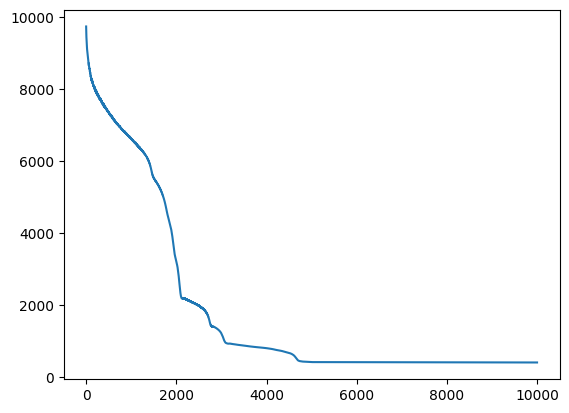

In [26]:
plt.plot(lossi)

### Step 2: Reference implementation using pytorch's .backward()
Nothing to do in Step 2, this code is provided for you as a reference

In [27]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [28]:
# reference code
torch.set_printoptions(linewidth=200)
import torch.nn as F

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        xloss = F.MSELoss()
        lsi = xloss(h2, yb) * yb.nelement()
        # backward
        for p in parameters:
            p.grad = None
        lsi.backward()
        # update
        lr = 0.1 / num_samples
        for p in parameters:
            p.data += -lr * p.grad
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [29]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 9739.25390625
step = 100, loss = 8368.6396484375
step = 200, loss = 7992.68701171875
step = 300, loss = 7720.29638671875
step = 400, loss = 7503.93310546875
step = 500, loss = 7352.43994140625
step = 600, loss = 7179.36376953125
step = 700, loss = 7036.6962890625
step = 800, loss = 6904.39208984375
step = 900, loss = 6768.669921875
step = 1000, loss = 6660.0673828125
step = 1100, loss = 6549.5
step = 1200, loss = 6418.8115234375
step = 1300, loss = 6258.0869140625
step = 1400, loss = 6024.8515625
step = 1500, loss = 5575.2978515625
step = 1600, loss = 5364.59765625
step = 1700, loss = 5095.408203125
step = 1800, loss = 4635.765625
step = 1900, loss = 4120.9599609375
step = 2000, loss = 3448.3359375
step = 2100, loss = 2568.770751953125
step = 2200, loss = 2158.4833984375
step = 2300, loss = 2116.86669921875
step = 2400, loss = 2059.064453125
step = 2500, loss = 1980.979248046875
step = 2600, loss = 1891.409423828125
step = 2700, loss = 1750.2545166015625
step = 2800, l

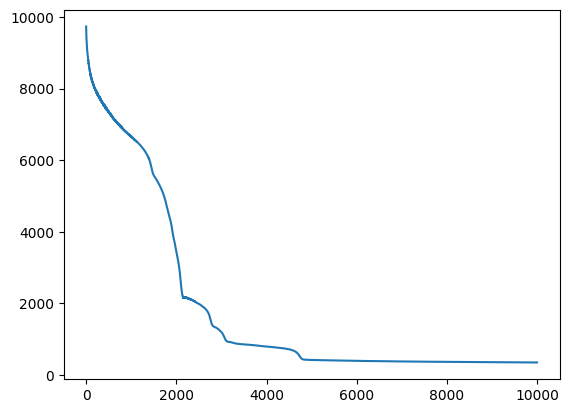

In [30]:
plt.plot(lossi)

### Step 3: Build the same MLP layer but with fully pytorch code (nn.Linear(), etc.)

In [31]:
# network dimensions
n_in = 784
n_hidden = 200
n_out = 10

In [32]:
X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

In [33]:
class MLP(nn.Module):

    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.n_in = n_in
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.layers = nn.ModuleList((
            nn.Linear(self.n_in, self.n_hidden),
            nn.Tanh(),
            nn.Linear(self.n_hidden, self.n_out),
            nn.Tanh()
        ))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model = MLP(n_in = 784, n_hidden = 50, n_out = 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [34]:
X_tr.shape, Y_tr.shape

(torch.Size([1000, 784]), torch.Size([1000, 10]))

In [35]:
y_pred = model(X_tr)

In [36]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=0.14834	accuracy (train, test): 0.10300	0.19700
step =   1000	loss=0.00064	accuracy (train, test): 1.00000	0.84700
step =   2000	loss=0.00016	accuracy (train, test): 1.00000	0.83400
step =   3000	loss=0.00019	accuracy (train, test): 1.00000	0.82500
step =   4000	loss=0.00004	accuracy (train, test): 1.00000	0.81900
step =   5000	loss=0.00003	accuracy (train, test): 1.00000	0.81900
step =   6000	loss=0.00003	accuracy (train, test): 1.00000	0.81800
step =   7000	loss=0.00002	accuracy (train, test): 1.00000	0.82200
step =   8000	loss=0.00009	accuracy (train, test): 1.00000	0.82300
step =   9000	loss=0.00010	accuracy (train, test): 1.00000	0.82100


On remarque qu'à la fin de l'entraînement, la précision sur l'ensemble d'entraînement est de 100% alors qu'elle est de 82,1% sur l'ensemble de test. Cela pourrait être signe d'overfitting, le modèle s'ajuste trop spécifiquement aux données d'entraînement et n'est pas capable de généraliser efficacement sur des données non vues. On va essayer d'améliorer la précision sur l'ensemble de test quitte à diminuer celle sur l'ensemble d'entraînement.

#### Exercise: try to improve accuracy!

##### On va d'abord essayer d'augmenter le taux d'apprentissage 1e-3 -> 1e-1 ou 1e-2

In [37]:
model = MLP(n_in = 784, n_hidden = 50, n_out = 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1)
loss_fn = nn.MSELoss()

In [38]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=0.15288	accuracy (train, test): 0.08000	0.08800
step =   1000	loss=1.15618	accuracy (train, test): 0.09100	0.07900
step =   2000	loss=1.04284	accuracy (train, test): 0.11600	0.12600
step =   3000	loss=1.03672	accuracy (train, test): 0.09700	0.08500
step =   4000	loss=0.97876	accuracy (train, test): 0.09700	0.08500
step =   5000	loss=1.01008	accuracy (train, test): 0.09700	0.08500
step =   6000	loss=1.07272	accuracy (train, test): 0.09700	0.08500
step =   7000	loss=1.08568	accuracy (train, test): 0.09700	0.08500
step =   8000	loss=1.05004	accuracy (train, test): 0.09700	0.08500
step =   9000	loss=1.04032	accuracy (train, test): 0.11600	0.12600


Précision très faible (pour ensemble d'entraînement et de test)

In [39]:
model = MLP(n_in = 784, n_hidden = 50, n_out = 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

In [40]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=0.14251	accuracy (train, test): 0.12800	0.14200
step =   1000	loss=0.00267	accuracy (train, test): 0.98900	0.75600
step =   2000	loss=0.00196	accuracy (train, test): 0.99300	0.74600
step =   3000	loss=0.00189	accuracy (train, test): 0.99200	0.74500
step =   4000	loss=0.00172	accuracy (train, test): 0.99200	0.73700
step =   5000	loss=0.00143	accuracy (train, test): 0.99400	0.73400
step =   6000	loss=0.00283	accuracy (train, test): 0.98500	0.76200
step =   7000	loss=0.00200	accuracy (train, test): 0.99100	0.76400
step =   8000	loss=0.00185	accuracy (train, test): 0.99300	0.77000
step =   9000	loss=0.00163	accuracy (train, test): 0.99200	0.77500


La précision a diminué aussi bien sur l'ensamble d'entraînement que sur l'ensemble de test.

##### Diminuer le nombre de neurones dans la couche cachée : 50 -> 20 ou 30

In [ ]:
model = MLP(n_in = 784, n_hidden = 20, n_out = 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [42]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=0.18817	accuracy (train, test): 0.05100	0.10400
step =   1000	loss=0.00333	accuracy (train, test): 0.99900	0.82400
step =   2000	loss=0.00089	accuracy (train, test): 1.00000	0.80900
step =   3000	loss=0.00042	accuracy (train, test): 1.00000	0.79600
step =   4000	loss=0.00024	accuracy (train, test): 1.00000	0.78900
step =   5000	loss=0.00016	accuracy (train, test): 1.00000	0.79100
step =   6000	loss=0.00011	accuracy (train, test): 1.00000	0.78900
step =   7000	loss=0.00009	accuracy (train, test): 1.00000	0.78400
step =   8000	loss=0.00010	accuracy (train, test): 1.00000	0.78100
step =   9000	loss=0.00006	accuracy (train, test): 1.00000	0.78200


In [43]:
model = MLP(n_in = 784, n_hidden = 30, n_out = 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [44]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=0.14495	accuracy (train, test): 0.06500	0.12200
step =   1000	loss=0.00110	accuracy (train, test): 1.00000	0.82700
step =   2000	loss=0.00028	accuracy (train, test): 1.00000	0.80200
step =   3000	loss=0.00013	accuracy (train, test): 1.00000	0.79500
step =   4000	loss=0.00007	accuracy (train, test): 1.00000	0.78900
step =   5000	loss=0.00005	accuracy (train, test): 1.00000	0.79000
step =   6000	loss=0.00005	accuracy (train, test): 1.00000	0.79200
step =   7000	loss=0.00003	accuracy (train, test): 1.00000	0.79300
step =   8000	loss=0.00002	accuracy (train, test): 1.00000	0.78500
step =   9000	loss=0.00003	accuracy (train, test): 1.00000	0.78300


Pas très concluant non plus...

##### Modifier la fonction de perte : MSEloss -> CrossEntropyLoss

In [45]:
model = MLP(n_in = 784, n_hidden = 50, n_out = 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [46]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=2.09453	accuracy (train, test): 0.12500	0.30200
step =   1000	loss=0.72467	accuracy (train, test): 0.99300	0.85900
step =   2000	loss=0.72415	accuracy (train, test): 0.99400	0.85900
step =   3000	loss=0.72409	accuracy (train, test): 0.99400	0.85500
step =   4000	loss=0.72406	accuracy (train, test): 0.99400	0.84800
step =   5000	loss=0.72405	accuracy (train, test): 0.99400	0.85200
step =   6000	loss=0.72404	accuracy (train, test): 0.99400	0.84700
step =   7000	loss=0.72403	accuracy (train, test): 0.99400	0.85300
step =   8000	loss=0.72403	accuracy (train, test): 0.99400	0.85100
step =   9000	loss=0.72403	accuracy (train, test): 0.99400	0.85000


Bien meilleur ! Il y a moins d'overfitting et la précision sur l'ensemble de test a légèrement augmenté. 

In [47]:
model = MLP(n_in = 784, n_hidden = 35, n_out = 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [48]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=2.09125	accuracy (train, test): 0.09400	0.29900
step =   1000	loss=0.72433	accuracy (train, test): 0.99500	0.84800
step =   2000	loss=0.72393	accuracy (train, test): 0.99500	0.84000
step =   3000	loss=0.72383	accuracy (train, test): 0.99500	0.84500
step =   4000	loss=0.72379	accuracy (train, test): 0.99500	0.84700
step =   5000	loss=0.72376	accuracy (train, test): 0.99500	0.84700
step =   6000	loss=0.72375	accuracy (train, test): 0.99500	0.84500
step =   7000	loss=0.72374	accuracy (train, test): 0.99500	0.84400
step =   8000	loss=0.88926	accuracy (train, test): 0.87600	0.67100
step =   9000	loss=0.88162	accuracy (train, test): 0.87900	0.66900


Moins bien...

##### Utiliser la régularisation L2 (weight_decay dans l'optimiseur Adamw)

In [ ]:
model = MLP(n_in = 784, n_hidden = 50, n_out = 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [50]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=2.08669	accuracy (train, test): 0.15100	0.30500
step =   1000	loss=0.72747	accuracy (train, test): 0.99200	0.85100
step =   2000	loss=0.72682	accuracy (train, test): 0.99200	0.85100
step =   3000	loss=0.72677	accuracy (train, test): 0.99200	0.84900
step =   4000	loss=0.72540	accuracy (train, test): 0.99300	0.85100
step =   5000	loss=0.72539	accuracy (train, test): 0.99300	0.85400
step =   6000	loss=0.72539	accuracy (train, test): 0.99300	0.85300
step =   7000	loss=0.72538	accuracy (train, test): 0.99300	0.85500
step =   8000	loss=0.72538	accuracy (train, test): 0.99300	0.85400
step =   9000	loss=0.72538	accuracy (train, test): 0.99300	0.85200


In [52]:
model = MLP(n_in = 784, n_hidden = 50, n_out = 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [53]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=2.09918	accuracy (train, test): 0.08200	0.34500
step =   1000	loss=0.72624	accuracy (train, test): 0.99300	0.85400
step =   2000	loss=0.72458	accuracy (train, test): 0.99400	0.84800
step =   3000	loss=0.72408	accuracy (train, test): 0.99400	0.85000
step =   4000	loss=0.72406	accuracy (train, test): 0.99400	0.85300
step =   5000	loss=0.72404	accuracy (train, test): 0.99400	0.85600
step =   6000	loss=0.72404	accuracy (train, test): 0.99400	0.84500
step =   7000	loss=0.72403	accuracy (train, test): 0.99400	0.84900
step =   8000	loss=0.72403	accuracy (train, test): 0.99400	0.84600
step =   9000	loss=0.72403	accuracy (train, test): 0.99400	0.84600


##### Early stopping

In [54]:
model = MLP(n_in = 784, n_hidden = 50, n_out = 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [55]:
# training
num_epochs = 10000
best_test_acc = 0  # Meilleure accuracy test
patience = 500  # Nombre d'époques sans amélioration avant d'arrêter
counter = 0  # Compteur d'époques sans amélioration

for n in range(num_epochs):
    # Forward pass
    y_pred = model(X_tr)
    
    # Calcul de la loss
    loss = loss_fn(y_pred, Y_tr)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Vérifier l'accuracy tous les 1000 itérations
    if n % 1000 == 0:
        with torch.no_grad():
            # Accuracy sur le train set
            acc_train = compute_accuracy(y_pred, Y_tr)
            
            # Accuracy sur le test set
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            
            # Affichage des résultats
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')
            
            # Vérification de l'amélioration de l'accuracy sur le test set
            if acc_test > best_test_acc:
                best_test_acc = acc_test
                counter = 0  # Réinitialiser le compteur si une amélioration est trouvée
            else:
                counter += 1  # Incrémenter le compteur si l'accuracy ne s'améliore pas
                
                # Arrêter l'entraînement si l'accuracy ne s'améliore pas après un certain nombre d'époques
                if counter >= patience:
                    print("Early stopping triggered.")
                    break


step =      0	loss=2.11816	accuracy (train, test): 0.07300	0.24800
step =   1000	loss=0.72573	accuracy (train, test): 0.99300	0.84500
step =   2000	loss=0.72414	accuracy (train, test): 0.99400	0.84600
step =   3000	loss=0.72408	accuracy (train, test): 0.99400	0.84200
step =   4000	loss=0.72406	accuracy (train, test): 0.99400	0.84200
step =   5000	loss=0.72405	accuracy (train, test): 0.99400	0.84400
step =   6000	loss=0.72404	accuracy (train, test): 0.99400	0.84300
step =   7000	loss=0.72403	accuracy (train, test): 0.99400	0.83700
step =   8000	loss=0.72403	accuracy (train, test): 0.99400	0.83500
step =   9000	loss=0.88279	accuracy (train, test): 0.88600	0.73500


Ne fonctionne pas vraiment...